In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import albumentations as A
from tensorflow.python.util.nest import map_structure, assert_same_structure
import tensorflow_probability as tfp
from tensorflow_datasets import load 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, BatchNormalization, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, binary_accuracy, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from tensorboard.plugins.hparams import api as hp
import wandb
#from wandb.keras import WandbCallback
import io
from PIL import Image
import datetime
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [7]:
dataset, dataset_info = load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

# Wandb Install, Login, Initialization and Configuration

In [20]:
!pip install wandb
!wandb login

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [9]:
#wandb.init(project="Malaria-Derection",)
#wandb.init(project="Malaria-Derection", sync_tensorboard=True)

In [87]:
#wandb.tensorboard.patch(root_logdir="./logs")
#wandb.init(project="Malaria-Detection", sync_tensorboard=True, save_code=False,notes="")

In [24]:
#wandb.init(project="Malaria-Detection", entity="neuralearn")

In [ ]:
wnadb.config = {
    #'BATCH_SIZE':128,
    'IM_SIZE':224,
    'LEARNING_RATE':0.001,
    "N_EPOCHS":100,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE':3,
    'N_STRIDES':1,
    'POOL_SIZE':2,
    #'PATCH_SIZE':2,
    'N_DENSE_1':128,
    'N_DENSE_2':32,
    #'NUM_CLASSES':3,
}

#CONFIGURATION = wandb.config

In [11]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(DATASET_SIZE * TRAIN_RATIO))

    
    val_test_dataset = dataset.skip(int(DATASET_SIZE * TRAIN_RATIO))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

    
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset


In [13]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0
TEST_RATIO = 0.4

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())

([(array([[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          ...,
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]]], dtype=uint8),
   0)],
 [],
 [(array([[[0, 0, 0],
           [0, 0,

In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\hamid\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin

In [6]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


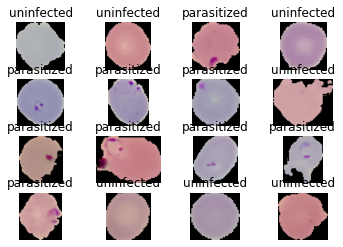

In [7]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

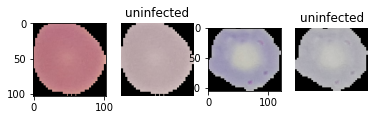

In [8]:
#This part can show why the model does not perform well when we adjust saturation
for i, (image, label) in enumerate(train_dataset.take(2)):
    ax = plt.subplot(1, 4, 2*i+1)
    plt.imshow(image)
    
    ax = plt.subplot(1, 4, 2*i+2)
    plt.imshow(tf.image.adjust_saturation(image, 0.3))
    
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

In [9]:
dataset_info.features['label'].int2str(1)

'uninfected'

# Data Augmentation


In [10]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [11]:
original_image, label = next(iter(train_dataset))

In [12]:
#augmented_image = tf.image.flip_left_right(original_image)

In [13]:
#augmented_image = tf.image.random_flip_up_down(original_image)

In [14]:
#augmented_image = tf.image.rot90(original_image)

In [43]:
#augmented_image = tf.image.adjust_brightness(original_image, delta=0.1)

In [16]:
#augmented_image = tf.image.random_saturation(original_image, lower=2, upper=5)

In [17]:
#augmented_image = tf.image.central_crop(original_image, 0.999)

In [12]:
augmented_image = tf.image.adjust_saturation(original_image, 0.3)

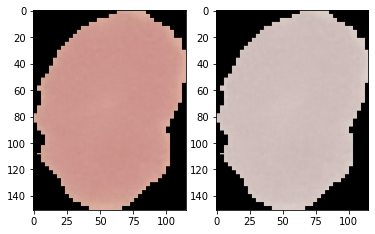

In [13]:
visualize(original_image, augmented_image)

In [14]:
IM_SIZE = 224
@tf.function
def resize_rescale(image, label):  
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [15]:
#tf.config.run_functions_eagerly(True, or False) this one can effect the tf.function

In [16]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])

In [17]:
### tf.image.augment
@tf.function
def augment(image, label):
    
    image, label = resize_rescale([image, label])
    
    image = tf.image.rot90(image)
    
    # Because saturation did not perform well so we comment it 
    #image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    image = tf.image.flip_left_right(image)
    return image, label

In [21]:
### tf.image.augment

#def augment(image, label):
    
    #image, label = resize_rescale(image, label)
    
    #image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.float32))
    
    #Because saturation did not perform well so we comment it 
    #image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    
    #image = tf.image.stateless_random_saturation(image, lower=0.3, upper=0.5)
    
    #image = tf.image.stateless_random_flip_left_right(image)
    
    #return image, label

In [18]:
# we define a class which inherits from keras layers

class RotNinety(Layer):
    def __init__(self, ):
        super().__init__()
        
    @tf.function    
    def call(self, image):
        return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.float32))

In [26]:
### tf.keras.layers augment

#augment_layers = tf.keras.Sequential([
    #RotNinety(),
    #RandomFlip(mode="horizontal", ),
    
#])

In [19]:
### tf.keras.layers augment

augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501), ),
    RandomFlip(mode="horizontal", ),
    #RandomRotation(factor=0.1)
    
])

In [20]:
@tf.function
def augment_layer(image, label):
    image, label = resize_rescale(image, label)
    return augment_layers(resize_rescale_layer(image), training=True) , label

In [21]:
#def augment_layer(image, label):
    #return augment_layer(image, training=True) , labels

In [30]:
#train_dataset = train_dataset.map(augmented)

In [31]:
#val_dataset = val_dataset.map(augmented)

In [32]:
#test_dataset = test_dataset.map(resize_rescale)

In [33]:
# because of doing resizing and rescaling on model I do not do it on test dataset
#test_dataset = test_dataset.map(resize_rescale_layer)

In [22]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [35]:
#train_dataset = (
    #train_dataset
    #.shuffle(buffer_size=8, reshuffle_each_iteration=True)
    #.map(augment_layer) ####again because model does all this I comment it
    #.batch(1) # Batch size of 32 cause an error so changing this to 1 will work better
    #.prefetch(tf.data.AUTOTUNE)
#)

In [36]:
#val_dataset = (
    #val_dataset
    #.shuffle(buffer_size=8, reshuffle_each_iteration=True)
    #.map(resize_rescale)
    #.batch(32)
    #.prefetch(tf.data.AUTOTUNE)
#)

In [37]:
#val_dataset = (
    #val_dataset
    #.shuffle(buffer_size=8, reshuffle_each_iteration=True)
    #.map(resize_rescale_layer) ####again because model does all this I comment it
    #.batch(1) # Batch size of 32 cause an error so changing this to 1 will work better
    #.prefetch(tf.data.AUTOTUNE)
#)

In [38]:
#test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
tfp.distributions.Beta(
    concentration1=0.2, concentration0=0.2, validate_args=False, allow_nan_stats=True,
    force_probs_to_zero_outside_support=False, name='Beta'
)

<tfp.distributions.Beta 'Beta' batch_shape=[] event_shape=[] dtype=float32>

In [24]:
lamda = tfp.distributions.Beta(0.2, 0.2)
print(lamda.sample(1)[0])

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


tf.Tensor(0.1764374, shape=(), dtype=float32)


# Mixup Data Augmentation

In [25]:
train_dataset_1 = train_dataset.shuffle(buffer_size=4096,).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=4096,).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [26]:
def mixup(train_dataset_1, train_dataset_2):
    
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
 
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]

    image = lamda * image_1 + (1 - lamda) * image_2

    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1 - lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

# CutMix Data Augmentation

In [27]:
def box(lamda):

    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

    r_w = x_b_r - r_x
    if (r_w == 0):
        r_w = 1
    r_h = y_b_r - r_y
    if (r_h == 0):
        r_h = 1

    return r_y, r_x, r_h, r_w   

In [28]:
def cutmix(train_dataset_1, train_dataset_2):
    
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    r_y, r_x, r_h, r_w = box(lamda)
    
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)

    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)

    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)
    image = image_1 - pad_1 + pad_2
    
    lamda = tf.cast(1 - (r_w * r_h) / (IM_SIZE * IM_SIZE), dtype=tf.float32)
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1 - lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

In [29]:
BATCH_SIZE = 32
train_dataset = (
     mixed_dataset
    .shuffle(buffer_size=4096, reshuffle_each_iteration=True)
    #.map(mixedup) 
    .map(cutmix)
    .batch(BATCH_SIZE) # Batch size of 32 cause an error so changing this to 1 will work better
    .prefetch(tf.data.AUTOTUNE)
)

In [30]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

tf.Tensor(
[1.9907951e-05 2.4555564e-01 0.0000000e+00 7.5444436e-01 7.5884885e-01
 7.6610327e-02 0.0000000e+00 1.0000000e+00 7.6753825e-01 0.0000000e+00
 1.3400829e-01 1.0000000e+00 0.0000000e+00 4.9823523e-04 1.0000000e+00
 2.4555564e-01 9.9280530e-01 0.0000000e+00 1.0000000e+00 0.0000000e+00
 1.0000000e+00 7.5444436e-01 1.0000000e+00 7.5444436e-01 8.9086413e-01
 1.0000000e+00 1.0000000e+00 7.5444436e-01 2.4555564e-01 7.6321352e-01
 9.2584103e-01 0.0000000e+00], shape=(32,), dtype=float32)


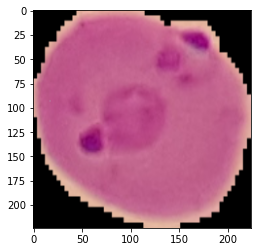

In [31]:
original_image, label = next(iter(train_dataset))
print(label)
plt.imshow(original_image[0])

In [32]:
val_dataset = (
    val_dataset
    .map(resize_rescale_layer) 
    .batch(BATCH_SIZE)
)

In [33]:
val_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [34]:
#crop = tf.image.crop_to_bounding_box(image_2, 20, 85, 120, 98)

#image_4 = tf.image.pad_to_bounding_box(crop, 20, 100, IM_SIZE, IM_SIZE)

#crop_model = tf.image.crop_to_bounding_box(image_1, 20, 100, 100, 98)

#image_5 = tf.image.pad_to_bounding_box(crop_model, 20, 100, IM_SIZE, IM_SIZE)
#image = image_1 - image_5 + image_4


# Albumentations

In [35]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    
    A.OneOf([A.HorizontalFlip(),
    A.VerticalFlip()], p=.03),
    
    A.RandomRotate90(),
    
    A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
    
    A.RandomBrightnessContrast(brightness_limit=0.2,
                            contrast_limit=0.2,
                            brightness_by_max=True,
                            always_apply=False,
                            p=0.5),
    
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, always_apply=False, p=0.5), 
    
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5)
])

In [36]:
def aug_albument(image):
    data = {"image":image}
    image = transforms(**data)
    image = image["image"]
    image = tf.cast(image/255., tf.float32)
    
    return image

In [37]:
def process_data(imge, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [38]:
BATCH_SIZE = 32
train_dataset_1 = (
     mixed_dataset
    .shuffle(buffer_size=4096, reshuffle_each_iteration=True)
    #.map(mixedup) 
    .map(process_data)
    .batch(BATCH_SIZE) # Batch size of 32 cause an error so changing this to 1 will work better
    .prefetch(tf.data.AUTOTUNE)
)

In [39]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

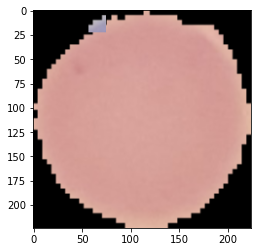

In [40]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

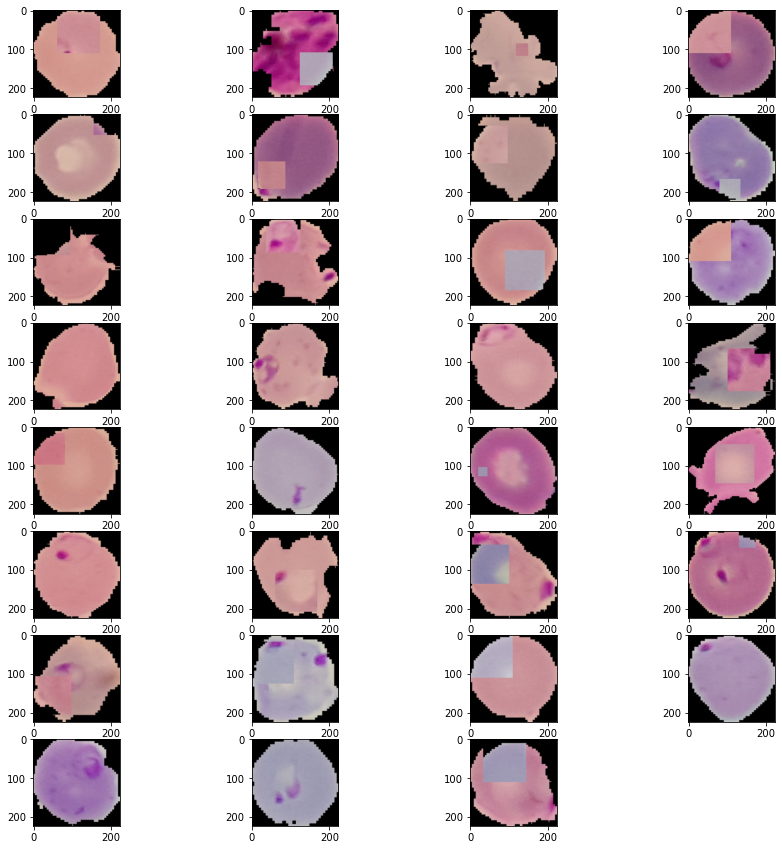

In [41]:
plt.figure(figsize=(15, 15))
for i in range(1, 32):
    plt.subplot(8, 4, i)
    plt.imshow(im[i])

# Wandb Dataset Versioning

In [17]:
dataset, dataset_info = load("malaria", with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [23]:
k = 0
for data in dataset[0]:
    with open("dataset/malaria_dataset_" +str(k) +  ".npz", mode="wb") as file:
        np.savez(file, data)
        
    k += 1
    if (k % 1000 == 0):
        print(k)

In [43]:
def load_original_data():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
    #run = wandb.init(project="my_project")
        original_data = wandb.Artifact("new_dataset", type="raw_data",
                                 description="The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
                                metadata={"source":"TFDS",
                                         "homepage":"https://lhncbc.nlm.nih.gov/publication/pub9932",
                                         "source_code":"tfds.image_classification.Malaria",
                                         "version":"1.0.0",
                                         "download_size":"337.08 MiB"})
        #dataset, dataset_info = tfds.load("malaria", with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

        original_data.add_dir("dataset/")
        
        #with original_data.new_file("original_data.npz", mode="wb") as file:
            #np.savez(file, dataset)

        run.log_artifact(original_data)

In [101]:
#run = wandb.init()
#artifact = run.use_artifact("Malaria-Detection/new_dataset:v1", type="raw_data")
#artifact_dir = artifact.download()

In [44]:
IM_SIZE = 224
def resize_rescale_1(image):  
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [45]:
def preprocess_data():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
    #run = wandb.init(project="my_project")
        artifact = run.use_artifact("Malaria-Detection/new_dataset:v1", type="raw_data")
        artifact_dir = artifact.download()
        
        preprocessed_data = wandb.Artifact("preprocessed_dataset", type="preprocessed_data",
                                 description="Preprocessed version of the Malaria dataset",
                                )
        
        dataset_x = []
        dataset_y = []
        artifact_directory = "artifacts/new_dataset:v1/"
        for f in os.listdir(artifact_directory)[:1000]:
            with open(artifact_directory + f, "rb") as file:
                npz_array = np.load(file, allow_pickle=True)
                x, y = npz_array.f.arr_0
                
                dataset_x.append(resize_rescale_1(x))
                dataset_y.append(resize_rescale_1(y))
                
        #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

        #preprocess_data.add_dir("dataset/")
        
        with preprocessed_data.new_file("preprocessed_dataset", mode="wb") as file:
            np.savez(file, [dataset_x, dataset_y])
            #np.savez(file, dataset)

        run.log_artifact(preprocessed_data)

# Data Splitting

In [ ]:
#run = wandb.init()

In [50]:
def split_data():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
    #run = wandb.init(project="my_project")
        artifact = run.use_artifact("Malaria-Detection/preprocessed_dataset:v1", type="preprocessed_dataset")
        artifact_dir = artifact.download()
        
        train_data = wandb.Artifact("train_dataset", 
                                    type="preprocessed_data",
                                 description="Training dataset",
                                )
        
        validation_data = wandb.Artifact("validation_dataset", 
                                    type="preprocessed_data",
                                 description="Validation dataset",
                                )
        
        test_data = wandb.Artifact("test_dataset", 
                                    type="preprocessed_data",
                                 description="Testing dataset",
                                )
        
        artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"
        
        with open(artifact_file + f, "rb") as file:
            npz_array = np.load(file, allow_pickle=True)
            arr = npz_array.f.arr_0
            
        train_split = 0.8
        val_split = 0.1
        test_split = 0.1
        
        data_len = len(arr[0])
        
        train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:(train_split*data_len)]]
        val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)]]
        test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):]]
        
        with train_data.new_file("train_dataset.npz", mode="wb") as file:
            np.savez(file, train_arr)
            #np.savez(file, dataset)
            
        with validation_data.new_file("val_dataset.npz", mode="wb") as file:
            np.savez(file, val_arr)
            
        with test_data.new_file("test_dataset.npz", mode="wb") as file:
            np.savez(file, test_arr)

        run.log_artifact(train_data)
        run.log_artifact(validation_data)
        run.log_artifact(test_data)

In [51]:
def augment_split(image, label):
       
    image = tf.image.rot90(image)
    
    image = tf.image.flip_left_right(image)
    
    return image

In [ ]:
#run = wandb.init()
#artifact = run.use_artifact("Malaria-Detection/train_dataset:v1", type="preprocessed_data")
#artifact_dir = artifact.download()

In [58]:
def augment_data():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

        artifact = run.use_artifact("Malaria-Detection/train_dataset:v1", type="raw_data")
        artifact_dir = artifact.download()
        
        augmented_data = wandb.Artifact(
            "Augmented_dataset",
             type="preprocessed_data",
             description="An Augmented version of the Malaria train dataset",
        )
    
        artifact_file = "artifacts/train_dataset:v/train_dataset.npz"
        
        dataset_x = []
        
        with open(artifact_file + f, "rb") as file:
            npz_array = np.load(file, allow_pickle=True)
            arr = npz_array.f.arr_0
               
                
            for im in arr[0]:
                dataset_x.append(augment_split(im))
            dataset_y = arr[1]   
        
        with augmented_data.new_file("augment_dataset.npz", mode="wb") as file:
            np.savez(file, [dataset_x, dataset_y])
            #np.savez(file, dataset)

        run.log_artifact(augmented_data)

# Wandb Model Versioning

In [57]:
def log_model():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
        
        untrained_model = wandb.Artifact(
            "Untrained_model",
             type="model",
             description="The initial version of our lenet model",
             metadata = CONFIGURATION       
        ) 
        
        filename = "lenet.h5"
        lenet_model.save(filename)
        
        untrained_model.add_file(filename)
        wandb.save(filename)

        run.log_artifact(untrained_model)

In [60]:
def train_log_model():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
        
        artifact = run.use_artifact("Malaria-Detection/augmented_dataset:v0", type="processed_data")
        artifact_dir = artifact.download()
        
        sequential_model = wandb.Artifact(
            "Trained_sequential_model",
             type="model",
             description="The trained version of our lenet model",
             metadata = CONFIGURATION       
        ) 
        
        artifact_file = "artifacts/Augmented_dataset:v/aug_dataset.npz"
        
        dataset_x = []
        
        with open(artifact_file + f, "rb") as file:
            npz_array = np.load(file, allow_pickle=True)
            
            arr = npz_array.f.arr_0
               
                
            for im in arr[0]:
                dataset_x.append(im)
            dataset_y = arr[1]   
            
        d_x = tf.convert_to_tensor(dataset_x, dtype=tf.float32)
        d_y = tf.convert_to_tensor(dataset_y, dtype=tf.float32)

        d = tf.data.Dataset.from_tensor_slices((d_x, d_y))

        train_d = (
            d
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
        )
        
        artifact = run.use_artifact("Malaria-Detection/Untrained_model:v0", type="processed_data")
        artifact_dir = artifact.download()
        
        artifact_file = "artifacts/Untrained_model:v0"
        
        lenet_model = tf.keras.models.load_model(artifact_file)
        
        metrics = [BinaryAccuracy(name="accuracy"), FalsePositives(name="fp"), FalseNegatives(name="fn"),
           TrueNegatives(name="tn"), TruePositives(name="tp"), Precision(name="precision"),
           Recall(name="recall"), AUC(name="auc")]
        
        lenet_model.compile(loss = BinaryCrossentropy(),
                   optimizer = Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
                   metrics = metrics)
        
        lenet_model.fit(
            train_d,
            epochs = 3,
            varbose = 1,
            callbacks = [WandbCallback()],
        )
        
        filename = "lenet_trained.h5"
        lenet_model.save(filename)
        
        trained_sequential_model.add_file(filename)
        wandb.save(filename)

        run.log_artifact(trained_sequential_model)

# Model Creation and Training

# Sequential API

In [44]:
# First Model

model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid",
           activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid",
           activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])

#model.summary()

# Functional API

In [45]:
#Second Model

func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)
x  = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)
x  = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model = Model(func_input, func_output, name="Lenet_Model")
#lenet_model.summary()

In [46]:
# Third Model
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)
x  = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)
x  = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)


feature_extractor = Model(func_input, output, name="Feature_Extractor")
#feature_extractor.summary()

In [47]:
#Third Model
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")
x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model = Model(func_input, func_output, name="Lenet_Model")
#lenet_model.summary()

In [48]:
# Fourth Model

feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

])

#feature_extractor_seq_model.summary()

In [77]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")
x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_seq = Model(func_input, func_output, name="Lenet_Model")
#lenet_model_seq.summary()

# Model Subclasses

In [49]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.max_1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)
        
        self.conv_2 = Conv2D(filters = 2*filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_2 = BatchNormalization()
        self.max_2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)
    
    
    def call(self, x, training):
        
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.max_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.max_2(x)
        
        return x
    
feature_subclassed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [50]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_subclassed(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model = Model(func_input, func_output, name="Lenet_Model")
#lenet_model.summary()

In [51]:
class LenetModel(Model):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

        self.flatten = Flatten()
        
        self.dense_1  = Dense(100, activation="relu")
        self.batch_1  = BatchNormalization()
        
        self.dense_2  = Dense(10, activation="relu")
        self.batch_2  = BatchNormalization()
        
        self.dense_3  = Dense(1, activation="sigmoid")
    
    def call(self, x, training):
        
        x = self.feature_extractor(x)
        
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)
        
        x = self.dense_3(x)
        
        return x
    
lenet_subclassed = LenetModel(8, 3, 1, "valid", "relu", 2)
lenet_subclassed(tf.zeros([1, 224, 224, 3]))
#lenet_subclassed.summary()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [52]:
class CustomDense(Layer):
    def __init__(self, output_units, activation):
        super(CustomDense, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_features_shape):
        self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape = (self.output_units, ), initializer="random_normal", trainable=True)
        
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.w) + self.b
        if (self.activation == "relu"):
            return tf.nn.relu(pre_output)
        elif (self.activation == "sigmoid"):
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output

In [53]:
dropout_rate = 0.3

custom_dense_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate), 
    
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    CustomDense(100, activation="relu"),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    
    CustomDense(10, activation="relu"),
    BatchNormalization(),
    CustomDense(1, activation="sigmoid")
])

#custom_dense_model.summary()

In [54]:
dropout_rate = 0.3
regularization_rate = 0.01

custom_dense_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate), 
    
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    Dense(100, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    
    Dense(10, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])

#custom_dense_model.summary()

In [55]:
dropout_rate = 0.2
regularization_rate = 0.01

#because of not doing resize rescaling on input data I do it on model
resize_rescale_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    
    resize_rescale_layer,
    augment_layers,
    
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate), 
    
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    Dense(100, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    
    Dense(10, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])

#resize_rescale_model.summary()

In [119]:
#IM_SIZE = CONFIGURATION["IM_SIZE"]
#DROPOUT_RATE = CONFIGURATION["DROPOUT_RATE"]
#REGULARIZATION_RATE = CONFIGURATION["REGULARIZATION_RATE"]
#N_FILTERS = CONFIGURATION["N_FILTERS"]
#KERNEL_SIZE = CONFIGURATION["KERNEL_SIZE"]
#POOL_SIZE = CONFIGURATION["POOL_SIZE"]
#N_STRIDES = CONFIGURATION["N_STRIDES"]

In [56]:
IM_SIZE = 224
dropout_rate = 0.2
regularization_rate = 0.01

lenet_2_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid",
           activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),
    
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid",
           activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),
    
    Dense(32, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dense(32, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])

#lenet_2_model.summary()

# Hyperparameter Tuning

In [29]:
wandb.config = {
    #'BATCH_SIZE':128,
    'IM_SIZE':224,
    'LEARNING_RATE':0.001,
    "N_EPOCHS":100,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE':3,
    'N_STRIDES':1,
    'POOL_SIZE':2,
    #'PATCH_SIZE':2,
    'N_DENSE_1':128,
    'N_DENSE_2':32,
    #'NUM_CLASSES':3,
}

#CONFIGURATION = wandb.config

In [92]:
sweep_config = {
    "name":"Malaria-Prediction-Sweep",
    "method":"random",
    "metrics":{
        "name": "accuracy",
        "goal": "maximize"
    }, 
    
    "parameters":{
        "N_DENSE_1":{
            "values":[16, 32, 64, 128]
        },
        
        "N_DENSE_2":{
            "values":[16, 32, 64, 128]
        },
        
        "DROPOUT_RATE":{
            "min":0.1,
            "max":0.4
        },
        
        "REGULARIZATION_RATE":{
            "distribution":"uniform",
            "min":0.001,
            "max":0.1
        },
        
        "N_EPOCHS":{
            "values":[16, 32, 64, 128]
        },
        "LEARNING_RATE":{
            "distribution":"uniform",
            "min":1e-4,
            "max":1e-2
        }
    }
}

#sweep_id = wandb.sweep(sweep_config)

In [90]:
# Hyperparameter tuning
IM_SIZE = 224
#dropout_rate = 0.3
#regularization_rate = 0.01

def model_tune(hparams):
    lenet_1_model = tf.keras.Sequential([
        InputLayer(input_shape=(config.IM_SIZE, config.IM_SIZE, 3)),

        Conv2D(filters=config.N_FILTERS, kernel_size=config.KERNEL_SIZE, strides=N_STRIDES, padding="valid",
               activation="relu", kernel_regularizer=L2(config.HP_REGULARIZATION_RATE)),
        BatchNormalization(),
        MaxPool2D(pool_size=config.POOL_SIZE, strides=config.N_STRIDES),
        Dropout(rate=config.DROPOUT_RATE),

        Conv2D(filters=config.N_FILTERS, kernel_size=config.KERNEL_SIZE, strides=N_STRIDES, padding="valid",
               activation="relu", kernel_regularizer=L2(config.HP_REGULARIZATION_RATE)),
        BatchNormalization(),
        MaxPool2D(pool_size=config.POOL_SIZE, strides=config.N_STRIDES),

        Flatten(),

        Dense(config.N_DENSE_1, activation="relu", kernel_regularizer=L2(config.HP_REGULARIZATION_RATE)),
        BatchNormalization(),
        Dropout(rate=config.DROPOUT_RATE),

        Dense(config.N_DENSE_2, activation="relu", kernel_regularizer=L2(config.HP_REGULARIZATION_RATE)),
        BatchNormalization(),

        Dense(1, activation="sigmoid")
    ])


    return lenet_2_model

In [94]:
def train_sweep():
    with wandb.init(project="Malaria-Derection", entity="neuralearn", config=config) as run:
        config = wandb.config
        model = model_tune(config)
        
        model.compile(
            optimizer + Adam(
                learinig_rate = config.LEARNING_RATE
            ),
            loss = "binary_crossentropy",
            metrics = ["accuracy"]
        )
        
        model.fit(val_dataset, epochs=config.N_EPOCHS, callbacks = [WandbCallback()])
            
count = 5 # number of runs to execute
#wandb.agent(sweep_id, function=train, count=count)

In [57]:
HP_NUM_UNITS_1 = hp.HParam("num_units_1", hp.Discrete([16, 32, 64, 128]))
HP_NUM_UNITS_2 = hp.HParam("num_units_2", hp.Discrete([16, 32, 64, 128]))
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.1, 0.2, 0.3, 0.4]))
HP_REGULARIZATION_RATE = hp.HParam("regularization_rate", hp.Discrete([0.0001, 0.001, 0.01, 0.1]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([1e-5, 1e-4, 1e-3, 1e-2]))

In [58]:
# Hyperparameter tuning
IM_SIZE = 224
#dropout_rate = 0.3
#regularization_rate = 0.01

def model_tune(hparams):
    lenet_1_model = tf.keras.Sequential([
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

        Conv2D(filters=6, kernel_size=3, strides=1, padding="valid",
               activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Dropout(rate=hparams[HP_DROPOUT]),

        Conv2D(filters=16, kernel_size=3, strides=1, padding="valid",
               activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),

        Flatten(),

        Dense(hparams[HP_NUM_UNITS_1], activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        Dropout(rate=hparams[HP_DROPOUT]),

        Dense(hparams[HP_NUM_UNITS_2], activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),

        Dense(1, activation="sigmoid")
    ])

    # Model Compilation

    lenet_1_model.compile(
        loss = "binary_crossentropy",
        optimizer = Adam(learning_rate=hparams[HP_LEARNING_RATE]),
        metrics = ['accuracy'],
        run_eagerly=True
        )

    history = lenet_1_model.fit(train_dataset, epochs=1)

    _, accuracy = lenet_1_model.evaluate(train_dataset)

    return accuracy

In [59]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    hparams = {
                        HP_NUM_UNITS_1: num_units_1,
                        HP_NUM_UNITS_2: num_units_2,
                        HP_DROPOUT: dropout_rate,
                        HP_REGULARIZATION_RATE: regularization_rate,
                        HP_LEARNING_RATE: learning_rate,
                    }
                    
                    file_writer = tf.summary.create_file_writer("logs/" + str(run_number))
                    
                    with file_writer.as_default():
                        hp.HParam(hparams)
                        accuracy = model_tune(hparams)
                        tf.summary.scalar("accuract ", accuracy, step=0)
                        
                    print(f"For the run {run_number}, hparams num_units_1 : {HP_NUM_UNITS_1}, num_units_2: {HP_NUM_UNITS_2}, dropout: {HP_DROPOUT}, regularization rate: {HP_REGULARIZATION_RATE}, learning Rate: {HP_LEARNING_RATE}, our hparams is {hparams}")
                    
                    run_number += 1

  7/517 [..............................] - ETA: 4:32 - loss: 0.8832 - accuracy: 0.2277

KeyboardInterrupt: 

# Callbacks

In [ ]:
class LossCallbacks(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\n For Epoch Number {epoch+1} the model has loss of {logs['loss']}")
        
    def on_batch_end(self, batch, logs):
        print(f"\n For Batch Number {batch+1} the model has loss of {logs}")

In [ ]:
test_dataset = test_dataset.batch(1)

# Custom Callback For Tensorboard

In [82]:
class LogImagesCallbackTensorboard(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []

        for x, y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = custom_dense_model.predict(np.array(inp)[:,0,...])
        print("labels ", labels, labels.dtype)
        print("predicted ", predicted, predicted.dtype)
        
        Threshold = 0.43534606

        cm = confusion_matrix(labels, predicted > Threshold)

        print(cm)

        plt.figure(figsize=(8, 8))

        sns.heatmap(cm, annot=True)
        plt.title(f"Confusion metrix - {Threshold}")
        plt.ylabel("Actual")
        plt.xlabel("predicted")
        plt.axis("off")
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format="png")
        
        image = tf.image.decode_png(buffer.getvalue(), channels=3)
        image = tf.expand_dims(image, axis=0)
        
        CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
        IMAGE_DIR = "./logs/" + CURRENT_TIME + "./images"
        
        image_writer = tf.summary.create_file_writer(IMAGE_DIR)
        
        with image_writer.as_default():
            tf.summary.image("Training data : ", image, step=epoch)

In [83]:
class LogImagesCallbackWandb(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []

        for x, y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = custom_dense_model.predict(np.array(inp)[:,0,...])
        print("labels ", labels, labels.dtype)
        print("predicted ", predicted, predicted.dtype)
        
        Threshold = 0.43534606

        cm = confusion_matrix(labels, predicted > Threshold)

        print(cm)

        plt.figure(figsize=(8, 8))

        sns.heatmap(cm, annot=True)
        plt.title(f"Confusion metrix - {Threshold}")
        plt.ylabel("Actual")
        plt.xlabel("predicted")
        plt.axis("off")
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format="png")
        
        image_array = tf.image.decode_png(buffer.getvalue(), channels=3)
        
        images = wandb.Image(image_array, caption=f"Confusion Matrix for epoch {epoch}", )
        
        wandb.log({"examples":images})
        

# Custom Callback For Wandb

In [61]:
class LogImagesCallbackWandbPlot(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []

        for x, y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = custom_dense_model.predict(np.array(inp)[:,0,...])
        print("labels ", labels, labels.dtype)
        print("predicted ", predicted, predicted.dtype)
        
        pred = []
        for i in range(len(predicted)):
            if (predicted[i][0] < 0.5):
                pred.append([1,0])

            else:
                pred.append([0,1])
                
        pred = np.array(pred)
            
        wandb.log({"Confusion Metrix" : wandb.plot.confusion_matrix(probs=pred,
                                                            y_true=lagels,
                                                            class_names=["Parasitized", "Uninfected"])})
        
        
        # ROC CURVE PLOT
        wandb.log({"ROC Curve ": roc_curve(
            y_true=labels,
            y_pred=pred,
            labels=["Parasitized", "Uninfected"],
        )})
        
        wandb.log({"loss": logs["loss"]})

In [ ]:
images = wandb.Image(, caption=, )

In [62]:
#labels = []
#inp = []

#for x, y in test_dataset.as_numpy_iterator():
    #labels.append(y)
    #inp.append(x)
#labels = np.array([i[0] for i in labels])
#predicted = lenet_1_model.predict(np.array(inp)[:,0,...])
#print("labels ", labels, labels.dtype)
#print("predicted ", predicted, predicted.dtype)

In [63]:
#pred = []
#for i in range(len(predicted)):
    #if (predicted[i][0] < 0.5):
       # pred.append([1,0])
        
    #else:
        #pred.append([0,1])
        
#print(pred)

In [ ]:
print(np.array(pred).shape)

# CSVLogger

In [64]:
csv_callback = CSVLogger(
    "loge.csv", separator=",", append=False
)

# Early Stoping

In [65]:
es_callback = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3, verbose=1,
    mode="auto", baseline=None, restore_best_weights=False
)

# Tensorboard

In [116]:
#!pip install -U tensorboard_plugin_profile 

In [117]:
#CURRENT_TIME = datetime.datetime.now().strftime("%d%m%y - %h%m%s")
#METRIC_DIR = r"E:\python\segmentation\DRIVE\Data\logs"#+ CURRENT_TIME + "./metrics"
#train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [95]:
LOG_DIR = "./logs/"# + CURRENT_TIME
print(LOG_DIR)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1, profile_batch="100,132")

./logs/


# LearningRate Scheduler

In [66]:
def scheduler(epoch, lr):
    if epoch < 1:
        learning_rate = lr
    
    else:
        learning_rate = lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
    
    with train_writer.as_default():
        tf.summary.scalar("Learning Rate", data=learning_rate, step=epoch)
        
    return learning_rate
    
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

# Model CheckPointing

In [67]:
filepath = r"E:\python\segmentation\DRIVE\Data\Checkpoints"
checkpoint_callback = ModelCheckpoint(
    filepath=filepath, monitor="accuracy", verbose=0, save_best_only=True,
    save_weights_only=False, mode="auto", save_freq="epoch",
)

# ReduceLearningRateOnPlateau

In [68]:
plateau_callback = ReduceLROnPlateau(
    monitor="accuracy", factor=0.1, patience=2, verbose=1
)

# Model Training

In [69]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [100]:
#model.compile(loss = BinaryCrossentropy(),
             #optimizer=Adam(learning_rate=0.01),
             #metrics=['accuracy'])

In [70]:
lenet_model.compile(loss = BinaryCrossentropy(),
                   optimizer = Adam(learning_rate=0.01),
                   metrics = ["accuracy"])

In [71]:
lenet_subclassed.compile(loss = BinaryCrossentropy(),
                   optimizer = Adam(learning_rate=0.01),
                   metrics = ["accuracy"])

In [72]:
custom_dense_model.compile(loss = BinaryCrossentropy(),
                   optimizer = Adam(learning_rate=0.01),
                   metrics = ["accuracy"])

In [73]:
resize_rescale_model.compile(loss = BinaryCrossentropy(),
    optimizer = Adam(learning_rate=0.01),
    metrics = ["accuracy"],
    # For understandin the meaning of an error which I have no idea of I use run_eagerly function
    #run_eagerly = True, # to train faster, now there is no error we can comment this of
)

# Custom Metric Class

In [74]:
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="Custom Accuracy", FACTOR=1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name=name, initializer="zeros")
    
    def update_state(self, y_ture, y_pred, sample_weight=None):
        
        output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred) * self.FACTOR
        self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32) / tf.cast(len(output), dtype=tf.float32)) 
    
    def result(self):
        
        return self.accuracy
    
    def reset_state(self):
        
        self.accuracy.assign(0.)

# Custom Metric Method (without parameters)

In [75]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

# Custom Metric Method (without parameters)

In [76]:
FACTOR = 1
def custom_accuracy(FACTOR):
    def metric(y_true, y_pred):
        return binary_accuracy(y_true, y_pred) * FACTOR
    return metric

# Custom Loss Class

In [77]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
    
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * self.FACTOR

# Custom Loss Function (with parameters)

In [78]:
def custom_binarycrossentropy(FACTOR):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * FACTOR
    return loss

# Custom Loss Method (without parameters)

In [79]:
def custom_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)

In [80]:
lenet_2_model.compile(loss = CustomBCE(FACTOR),
    optimizer = Adam(learning_rate=0.0001),
    metrics = CustomAccuracy(),
    )

In [98]:
#history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1)

In [99]:
#history_1 = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1)

In [100]:
#history_2 = lenet_subclassed.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1)

In [ ]:
#history3 = custom_dense_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[LossCallbacks(), csv_call])

In [ ]:
#history3 = custom_dense_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[es_callback])

In [ ]:
#history3 = custom_dense_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[scheduler_callback])

In [ ]:
#history3 = custom_dense_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[checkpoint_callback])

In [ ]:
#history3 = custom_dense_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1,) # callbacks=[plateau_callback])

In [ ]:
#history_4 = resize_rescale_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1,) # callbacks=[plateau_callback])

In [ ]:
#The mixup data augmentation does not seem work well for this dataset
#history_5 = lenet_2_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1,) # callbacks=[plateau_callback])

In [81]:
metrics = [BinaryAccuracy(name="accuracy"), FalsePositives(name="fp"), FalseNegatives(name="fn"),
           TrueNegatives(name="tn"), TruePositives(name="tp"), Precision(name="precision"),
           Recall(name="recall"), AUC(name="auc")]

FACTOR = 1
LABELS = ["Parasitizes", "Uninfected"]

In [113]:
#Training with Tensorboard

#history = lenet_2_model.fit(train_dataset, validation_data=val_dataset, epochs=CONFIGURATION["N_EPOCHS"], verbose=1, callbacks=[tensorboard_callback, scheduler_callback])

# Fiting The Model With Wandb Callback

In [120]:
#history = lenet_2_model.fit(train_dataset, validation_data=val_dataset, epochs=CONFIGURATION["N_EPOCHS"], verbose=1,
                            #callbacks=[WandbCallback(validation_data=val_dataset,
                            #labels=LABELS,
                            #data_type = image,)])

In [ ]:
#wandb.finish() LogImagesCallbackWandb

In [ ]:
#history = lenet_2_model.fit(train_dataset, validation_data=val_dataset, epochs=CONFIGURATION["N_EPOCHS"], verbose=1,
                            #callbacks=[LogImagesCallbackWandb()])

# Biulding Custom Fit Function 

In [ ]:
OPTIMIZER = Adam(learning_rate=0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = 3

# Custom Training Loop

In [ ]:
#CURRENT_TIME = datetime.datetime.now().strftime("%d%m%y - %h%m%s")
CUSTOM_TRAIN_DIR = r"E:\python\segmentation\DRIVE\Data\logs"#+ CURRENT_TIME + "/custom/train"
#CUSTOM_VAL_DIR = r"E:\python\segmentation\DRIVE\Data\logs"+ CURRENT_TIME + "/custom/val"
custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
#custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [84]:
@tf.function
def training_block(x_batch, y_batch):
    
    with tf.GradientTape() as recorder:
        y_pred = lenet_2_model(x_batch, training=True)
        loss = custom_bce(y_batch, y_pred)
    
    wandb.log({"loss": loss.numpy()})
    
    partial_derivative = recorder.gradient(loss, lenet_2_model.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivative, lenet_2_model.trainable_weights))
        
    METRIC.update_state(y_batch, y_pred)
    return loss

In [ ]:
@tf.function
def val_block(x_batch_val, y_batch_val):
    

    y_pred_val = lenet_2_model(x_batch_val, training=False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
        
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val  

In [ ]:
#for epoch in range(EPOCHS):
    #print(f"Traning starts for epoch number {epoch+1}")
    #for step, (x_batch, y_batch) in enumerate(train_dataset):
        #loss = training_block(x_batch, y_batch)
    
    #print("Training Loss : ", loss)
    #print("The Accuracy is : ", METRIC.result())
    #METRIC.reset_states()
    
    #for (x_batch_val, y_batch_val) in val_dataset:
        #loss_val = val_block(x_batch_val, y_batch_val)
    
    #print("The Validation Loss : ", loss_val)
    #print("The Validation Accuracy is : ", METRIC_VAL.result())
    
    #METRIC_VAL.reset_states()

In [ ]:
def trian_model(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
    for epoch in range(EPOCHS):
        print(f"Traning starts for epoch number {epoch+1}")
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            loss = training_block(x_batch, y_batch)

        print("Training Loss : ", loss)
        print("The Accuracy is : ", METRIC.result())
        
        # Training Process
        with custom_train_writer.as_default():
            tf.summary.scalar("Training loss ", data=loss, step=epoch)
            
        with custom_train_writer.as_default():
            tf.summary.scalar("Training Accuracy loss ", data=METRIC.result(), step=epoch)
            
        METRIC.reset_states()

        for (x_batch_val, y_batch_val) in val_dataset:
            loss_val = val_block(x_batch_val, y_batch_val)

        print("The Validation Loss : ", loss_val)
        print("The Validation Accuracy is : ", METRIC_VAL.result())
        
        # Validation Process
        with custom_val_writer.as_default():
            tf.summary.scalar("Validation loss ", data=loss_val, step=epoch)
            
        with custom_val_writer.as_default():
            tf.summary.scalar("Validation Accuracy loss ", data=METRIC_VAL.result(), step=epoch)

        METRIC_VAL.reset_states()
        
    print("Training Complete .!")

In [ ]:
#trian_model(lenet_2_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

In [ ]:
##########This is in eager mode
#for epoch in range(EPOCHS):
    #print(f"Training starts for epoch number {epoch}")
    
    #Training Step
    #for step, (x_batch, y_batch) in enumerate(train_dataset):        
        #with tf.GradientTape() as recorder:
            #y_pred = lenet_2_model(x_batch, training=True)
            #loss = custom_bce(y_batch, y_pred)
    
        #partial_derivative = recorder.gradient(loss, lenet_2_model.trainable_weights)
        #OPTIMIZER.apply_gradients(zip(partial_derivative, lenet_2_model.trainable_weights))
        
        #METRIC.update_state(y_batch, y_pred)
        
        
    #print("Training loss ", loss)
        
    #print("The accuracy is : ", METRIC.result())
    #METRIC.reset_states()
     
    #Validation Step
    #for (x_batch_val, y_batch_val) in val_dataset:
        #y_pred_val = lenet_2_model(x_batch_val, training=False)
        #loss_val = custom_bce(y_batch_val, y_pred_val)
        
        #METRIC_VAL.update_state(y_batch_val, y_pred_val)
        
    #print("The Validation loss : ", loss_val)
        
    #print("The Validation accuracy is : ", METRIC_VAL.result())
    #METRIC_VAL.reset_states()
        


In [ ]:
print(history.params)

# Vsualizations

In [ ]:
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir=r'E:\python\segmentation\DRIVE\Data\logs'

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(['train_loss'])
plt.show()

In [ ]:
plt.plot(history3.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title("Model loss")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(['train_accuracy'])
plt.show()

# Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

In [ ]:
custom_dense_model.evaluate(test_dataset)

# Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [ ]:
labels = np.array([i[0] for i in labels])
print(labels)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

In [ ]:
predicted = custom_dense_model.predict(np.array(inp)[:,0,...])

In [ ]:
print(predicted[:,0])

In [ ]:
Threshold = 0.5

cm = confusion_matrix(labels, predicted > Threshold)

print(cm)

#plt.figure(figsize=(8, 8))

#sns.heatmap(cm, annot=True)
#plt.title("Confusion metrix - {}".format(Threshold))
#plt.ylabel("Actual")
#plt.xlabel("predicted")

In [ ]:
Threshold = 0.43534606

cm = confusion_matrix(labels, predicted > Threshold)

print(cm)

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title("Confusion metrix - {}".format(Threshold))
plt.ylabel("Actual")
plt.xlabel("predicted")

# ROC Plot

In [ ]:
fp, tp, threshold = roc_curve(labels, predicted)
plt.figure(figsize=(8, 8))
plt.plot(fp, tp)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.grid()

skip = 100
for i in range(0, len(threshold), skip):
    plt.text(fp[i], tp[i], threshold[i])
plt.show()

In [ ]:
custom_dense_model.predict(test_dataset.take(1))[0][0]

In [ ]:
def parasite_or_not(x):
    if (x<0.5):
        return str("P")
    else:
        return str("U")

In [ ]:
parasite_or_not(custom_dense_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(custom_dense_model.predict(image)[0][0])))
    plt.axis("off")